<a href="https://colab.research.google.com/github/SSR-ds/Time-Series-with-Python/blob/main/Apache_Spark_and_Prophet_(Multiple_Time_Series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"  
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [2]:
!java -version

openjdk version "1.8.0_275"
OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)


In [3]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 64kB/s 
     |████████████████████████████████| 204kB 43.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=11d0e182ef28d0e0e72fe284ef48eefb0bca8bd685f7e0251b82e05604026e47
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [4]:
!pip install pyarrow==0.15.1

     |████████████████████████████████| 59.2MB 88kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [5]:
!pip install fbprophet

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
%matplotlib inline

from fbprophet import Prophet

In [7]:
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.master('local').getOrCreate()

In [8]:
from google.colab import files
uploaded = files.upload()

Saving weekly_sales_data.csv to weekly_sales_data.csv


In [9]:
df1 = pd.read_csv('weekly_sales_data.csv')

In [10]:
df1

,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000
...,...,...,...
495,12/15/2019,31,401803.3590
496,12/15/2019,35,135799.1429
497,12/15/2019,38,115424.2250
498,12/15/2019,41,103375.0000


In [11]:
df1['date'] = pd.to_datetime(df1['date'])

In [12]:
df1

,date,store_id,sales
0,2019-01-06,25,736657.2267
1,2019-01-06,26,233711.0000
2,2019-01-06,28,692156.3794
3,2019-01-06,29,213706.8000
4,2019-01-06,30,266455.0000
...,...,...,...
495,2019-12-15,31,401803.3590
496,2019-12-15,35,135799.1429
497,2019-12-15,38,115424.2250
498,2019-12-15,41,103375.0000


In [13]:
df1.dtypes

date        datetime64[ns]
store_id             int64
sales              float64
dtype: object

In [14]:
df1.isnull().sum()

date        0
store_id    0
sales       0
dtype: int64

In [15]:
df1.nunique()

date         50
store_id     10
sales       500
dtype: int64

In [16]:
df1.describe()

,store_id,sales
count,500.0000,5.000000e+02
mean,32.7000,4.470800e+05
std,6.1714,2.970660e+05
min,25.0000,1.278800e+04
25%,28.0000,2.526557e+05
50%,30.5000,3.150259e+05
75%,38.0000,6.845418e+05
max,44.0000,1.631585e+06


In [17]:
df1['store_id'].value_counts()

44    50
41    50
38    50
35    50
31    50
30    50
29    50
28    50
26    50
25    50
Name: store_id, dtype: int64

In [18]:
df2 = df1.set_index('date')

In [19]:
df2

,store_id,sales
date,,
2019-01-06,25,736657.2267
2019-01-06,26,233711.0000
2019-01-06,28,692156.3794
2019-01-06,29,213706.8000
2019-01-06,30,266455.0000
...,...,...
2019-12-15,31,401803.3590
2019-12-15,35,135799.1429
2019-12-15,38,115424.2250


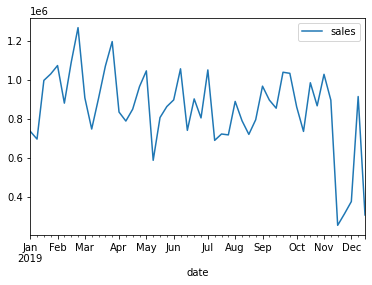

In [20]:
df2.query("store_id==25")[['sales']].plot();

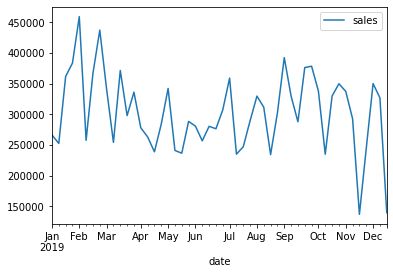

In [21]:
df2.query("store_id==30")[['sales']].plot();

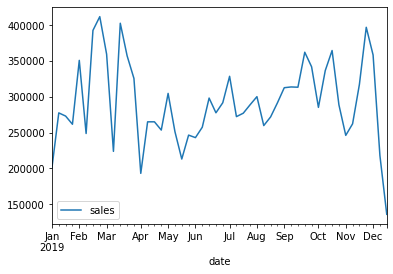

In [22]:
df2.query("store_id==35")[['sales']].plot();

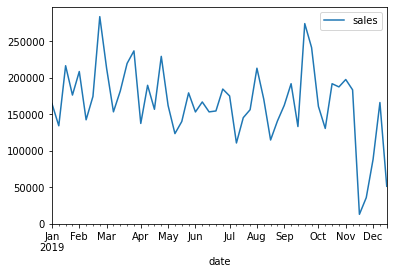

In [23]:
df2.query("store_id==44")[['sales']].plot();

In [24]:
spark_df = spark.createDataFrame(df1)

In [25]:
#head
spark_df.show(5)

+-------------------+--------+-----------+
|               date|store_id|      sales|
+-------------------+--------+-----------+
|2019-01-06 00:00:00|      25|736657.2267|
|2019-01-06 00:00:00|      26|   233711.0|
|2019-01-06 00:00:00|      28|692156.3794|
|2019-01-06 00:00:00|      29|   213706.8|
|2019-01-06 00:00:00|      30|   266455.0|
+-------------------+--------+-----------+
only showing top 5 rows



In [26]:
#info
spark_df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- store_id: long (nullable = true)
 |-- sales: double (nullable = true)



In [27]:
#count
spark_df.count()

500

In [28]:
#spark is lazy evluation framework that requires attributes like show to perfom its function
spark_df.select(['store_id']).groupBy('store_id').agg({'store_id':'count'}).show()

+--------+---------------+
|store_id|count(store_id)|
+--------+---------------+
|      26|             50|
|      29|             50|
|      31|             50|
|      25|             50|
|      41|             50|
|      28|             50|
|      44|             50|
|      35|             50|
|      38|             50|
|      30|             50|
+--------+---------------+



In [29]:
#pushing it into a Temp view to run SQL Queries and so on
spark_df.createOrReplaceTempView('sales')

In [30]:
spark.sql("select store_id, count(*) from sales group by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      26|      50|
|      29|      50|
|      31|      50|
|      25|      50|
|      41|      50|
|      28|      50|
|      44|      50|
|      35|      50|
|      38|      50|
|      30|      50|
+--------+--------+



In [31]:
sql_format = 'SELECT store_id, date as ds, sum(sales) as y FROM sales group by store_id, ds order by store_id, ds'

In [32]:
spark.sql(sql_format).show()

+--------+-------------------+------------------+
|store_id|                 ds|                 y|
+--------+-------------------+------------------+
|      25|2019-01-06 00:00:00|       736657.2267|
|      25|2019-01-13 00:00:00|       696457.1717|
|      25|2019-01-20 00:00:00|        996876.875|
|      25|2019-01-27 00:00:00|        1029737.05|
|      25|2019-02-03 00:00:00|       1072873.705|
|      25|2019-02-10 00:00:00|       880462.4681|
|      25|2019-02-17 00:00:00|        1088756.78|
|      25|2019-02-24 00:00:00|       1266928.313|
|      25|2019-03-03 00:00:00|       907510.1217|
|      25|2019-03-10 00:00:00|       747920.9824|
|      25|2019-03-17 00:00:00|       904750.3158|
|      25|2019-03-24 00:00:00|1069857.5890000002|
|      25|2019-03-31 00:00:00|       1195574.314|
|      25|2019-04-07 00:00:00|       834911.3333|
|      25|2019-04-14 00:00:00|       788777.4167|
|      25|2019-04-21 00:00:00|       849603.4333|
|      25|2019-04-28 00:00:00|        965521.165|


In [33]:
spark_df.explain()

== Physical Plan ==
*(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




In [34]:
spark_df.rdd.getNumPartitions()

1

In [35]:
breaking_store_part = (spark.sql(sql_format).repartition(spark.sparkContext.defaultParallelism,['store_id'])).cache()

In [36]:
breaking_store_part

DataFrame[store_id: bigint, ds: timestamp, y: double]

In [37]:
breaking_store_part.explain()

== Physical Plan ==
InMemoryTableScan [store_id#1L, ds#82, y#83]
   +- InMemoryRelation [store_id#1L, ds#82, y#83], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_id#1L, 1), false, [id=#147]
            +- *(3) Sort [store_id#1L ASC NULLS FIRST, ds#82 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store_id#1L ASC NULLS FIRST, ds#82 ASC NULLS FIRST, 200), true, [id=#143]
                  +- *(2) HashAggregate(keys=[store_id#1L, date#0], functions=[sum(sales#2)])
                     +- Exchange hashpartitioning(store_id#1L, date#0, 200), true, [id=#139]
                        +- *(1) HashAggregate(keys=[store_id#1L, date#0], functions=[partial_sum(sales#2)])
                           +- *(1) Scan ExistingRDD[date#0,store_id#1L,sales#2]




In [52]:
from pyspark.sql.types import *

result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('store_id',IntegerType()),
  StructField('y',DoubleType()),
  StructField('yhat',DoubleType()),
  StructField('yhat_upper',DoubleType()),
  StructField('yhat_lower',DoubleType())
  ])

In [69]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_sales( store_pd ):

  model = Prophet(interval_width=0.95,seasonality_mode = 'multiplicative', weekly_seasonality=True, yearly_seasonality=True)

  model.fit( store_pd )

  future_pd = model.make_future_dataframe(
    periods=10, 
    freq='w'
    )
  
  forecast_pd = model.predict( future_pd )  
  
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  st_pd = store_pd[['ds','store_id','y']].set_index('ds')
  
  results_pd = f_pd.join( st_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)
  
  results_pd['store_id'] = store_pd['store_id'].iloc[0]

  return results_pd[ ['ds', 'store_id','y', 'yhat', 'yhat_upper', 'yhat_lower'] ]

In [70]:
from pyspark.sql.functions import current_date

In [71]:
results = (
    breaking_store_part
    .groupBy('store_id')
    .apply(forecast_sales)
    .withColumn('training_date', current_date())
    )

/usr/local/lib/python3.6/dist-packages/pyspark/sql/pandas/group_ops.py:76: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [72]:
results.cache()

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [73]:
results.explain()

== Physical Plan ==
InMemoryTableScan [ds#1873, store_id#1874, y#1875, yhat#1876, yhat_upper#1877, yhat_lower#1878, training_date#1885]
   +- InMemoryRelation [ds#1873, store_id#1874, y#1875, yhat#1876, yhat_upper#1877, yhat_lower#1878, training_date#1885], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(2) Project [ds#1873, store_id#1874, y#1875, yhat#1876, yhat_upper#1877, yhat_lower#1878, 18596 AS training_date#1885]
            +- FlatMapGroupsInPandas [store_id#1L], forecast_sales(store_id#1L, ds#82, y#83), [ds#1873, store_id#1874, y#1875, yhat#1876, yhat_upper#1877, yhat_lower#1878]
               +- *(1) Sort [store_id#1L ASC NULLS FIRST], false, 0
                  +- InMemoryTableScan [store_id#1L, store_id#1L, ds#82, y#83]
                        +- InMemoryRelation [store_id#1L, ds#82, y#83], StorageLevel(disk, memory, deserialized, 1 replicas)
                              +- Exchange hashpartitioning(store_id#1L, 1), false, [id=#147]
                    

In [74]:
results.show()

+-------------------+--------+------------------+------------------+------------------+------------------+-------------+
|                 ds|store_id|                 y|              yhat|        yhat_upper|        yhat_lower|training_date|
+-------------------+--------+------------------+------------------+------------------+------------------+-------------+
|2019-01-06 00:00:00|      25|       736657.2267| 712575.0694095818| 955669.7604814962|475053.57531185116|   2020-11-30|
|2019-01-13 00:00:00|      25|       696457.1717| 743751.7568979745| 967820.0202085612|507835.90182197077|   2020-11-30|
|2019-01-20 00:00:00|      25|        996876.875| 972909.8778074606|1198168.0397453534| 736719.3955313421|   2020-11-30|
|2019-01-27 00:00:00|      25|        1029737.05|1034447.5557655566|1264807.2380089804| 804014.7473959223|   2020-11-30|
|2019-02-03 00:00:00|      25|       1072873.705| 986365.7266813249|1228303.3733029137| 753883.9728926593|   2020-11-30|
|2019-02-10 00:00:00|      25|  

In [75]:
results.coalesce(1)

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [76]:
results.count()

600

In [77]:
results.createOrReplaceTempView('forecast')

In [78]:
spark.sql("select store_id, count(*) from forecast group by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      31|      60|
|      28|      60|
|      26|      60|
|      44|      60|
|      41|      60|
|      35|      60|
|      38|      60|
|      25|      60|
|      29|      60|
|      30|      60|
+--------+--------+



In [79]:
df3 = results.toPandas()

In [80]:
df3

,ds,store_id,y,yhat,yhat_upper,yhat_lower,training_date
0,2019-01-06,25,7.366572e+05,7.125751e+05,9.556698e+05,475053.575312,2020-11-30
1,2019-01-13,25,6.964572e+05,7.437518e+05,9.678200e+05,507835.901822,2020-11-30
2,2019-01-20,25,9.968769e+05,9.729099e+05,1.198168e+06,736719.395531,2020-11-30
3,2019-01-27,25,1.029737e+06,1.034448e+06,1.264807e+06,804014.747396,2020-11-30
4,2019-02-03,25,1.072874e+06,9.863657e+05,1.228303e+06,753883.972893,2020-11-30
...,...,...,...,...,...,...,...
595,2020-01-26,44,NaN,-9.504370e+02,5.692397e+04,-68688.801733,2020-11-30
596,2020-02-02,44,NaN,-4.299515e+03,5.314038e+04,-59781.909485,2020-11-30
597,2020-02-09,44,NaN,-7.459837e+03,6.121451e+04,-69991.330785,2020-11-30
598,2020-02-16,44,NaN,-1.289796e+04,5.247587e+04,-73264.625255,2020-11-30


In [81]:
df3 = df3.set_index('ds')

In [82]:
df3.head()

,store_id,y,yhat,yhat_upper,yhat_lower,training_date
ds,,,,,,
2019-01-06,25,7.366572e+05,7.125751e+05,9.556698e+05,475053.575312,2020-11-30
2019-01-13,25,6.964572e+05,7.437518e+05,9.678200e+05,507835.901822,2020-11-30
2019-01-20,25,9.968769e+05,9.729099e+05,1.198168e+06,736719.395531,2020-11-30
2019-01-27,25,1.029737e+06,1.034448e+06,1.264807e+06,804014.747396,2020-11-30
2019-02-03,25,1.072874e+06,9.863657e+05,1.228303e+06,753883.972893,2020-11-30


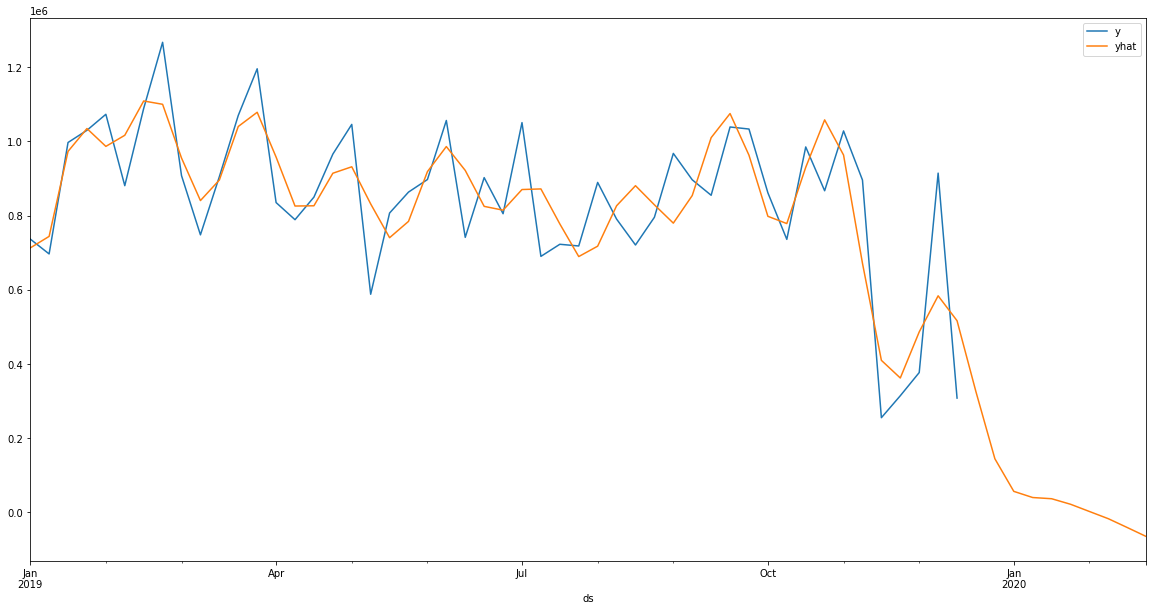

In [85]:
df3.query('store_id==25')[['y','yhat']].plot(figsize=(20,10))

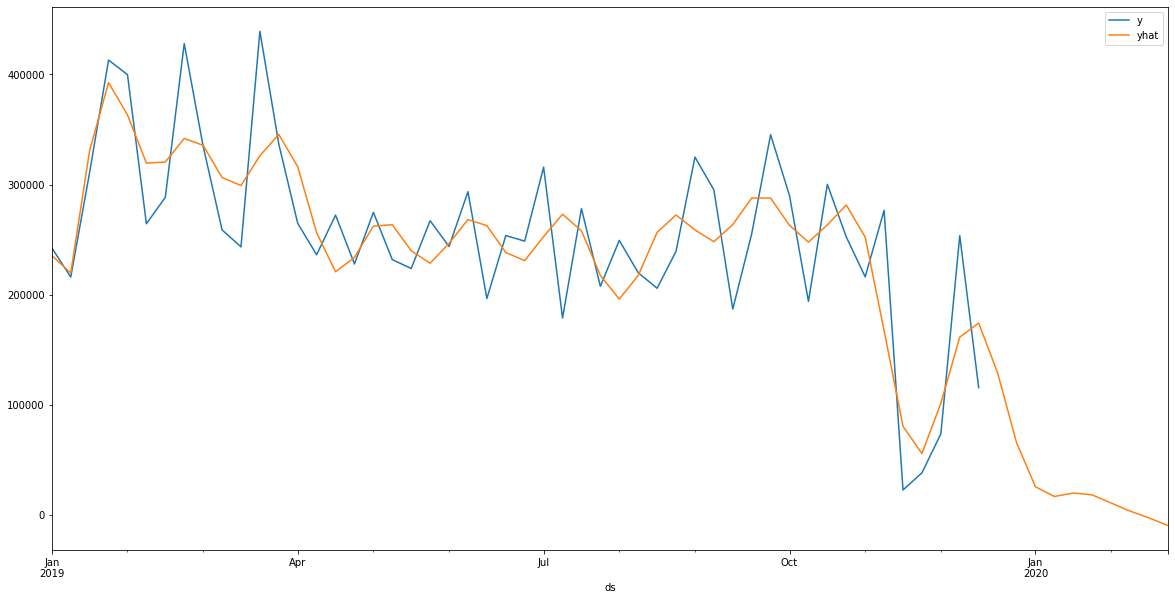

In [86]:
df3.query('store_id==38')[['y','yhat']].plot(figsize=(20,10))